# General considerations
We aim at classifying intensity and morphometric patterns measured on a population of DAPI stained nuclei in WSI. The classification should be interpretable from a standard biological point of view, suggesting a robust mapping between unsupervised classes and typical cell types (eg cancer, immuno and stroma).

The approach we take is describe by the following steps: 
- first, we learn the manifold of the morphometric features (we use UMAP for this) and represent it a 3D point cloud
- second, we segment the point cloud based on the curvature evaluated in each point's neighborhood
- third, we use a hierarchical clustering approach to analyse the points with lowest curvature (first quartile)

This notebook details the observations that led to the above euristic approach.

In [21]:
'''
Load the necessary libraries
'''

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

import hdbscan

import os
import glob

from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA
import numpy as np
import pandas as pd

In [68]:
'''
Load the morphology data and their pre-processed UMAP 3D embedding 
'''

usecols = (1,2,3,4,5,6,7,8) # include all fields

# set the filenames
embedding_filename = '/home/garner1/wsi-data/npy/id'+str(13)+'_clusterable_embedding.morphology.npy'
morphology_filename = '/home/garner1/wsi-data/npy/'+str(13)+'.txt.woInf.gz'

# load the data 
embedding = np.load(embedding_filename, allow_pickle=True)
morphology = np.loadtxt(morphology_filename, delimiter="\t", skiprows=True, usecols=usecols)

# subsample the point cloud to speed up computations
sample_size = 100000
subidx = np.random.randint(embedding.shape[0], size=sample_size)
subsample = embedding[subidx,:]

#df_embedding = pd.DataFrame(data=subsample, columns=['x','y','z'])
#df_morphology = pd.DataFrame(data=morphology[subidx,:], columns=['cx','cy','area','perimeter','eccentricity','circularity','mean_intensity','tot_intensity'])

df_embedding = pd.DataFrame(data=embedding, columns=['x','y','z'])
df_morphology = pd.DataFrame(data=morphology, columns=['cx','cy','area','perimeter','eccentricity',
                                                       'circularity','mean_intensity','tot_intensity'])

In [43]:
'''
Visualize the 3D UMAP representation of the morphology
'''
fig = px.scatter_3d(df_embedding.sample(n=50000,axis=0), x="x", y="y", z="z")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.write_html('id13.3Dumap.html', auto_open=True)

Note that to facilitate the visualization we sampled 50.000 points from the entire cloud.

As can be seen from the 3d UMAP visualization the point cloud does not show any relevant discontinuity that can be immediately exploited to identify morphological clusters.

We need to look more carefully to the point cloud.

Let's start by coloring the points based on the decile of each single morphological feature (area, perimeter, circularity, etc.) to see where they are located on the point cloud. We use deciles because the raw feature distributions are not spread enough to visualize what is a large value and what is a small value.

In [ ]:
df = pd.concat([df_morphology, df_embedding], axis=1)

for feature in ['area','perimeter','eccentricity','circularity','mean_intensity','tot_intensity']:
    df['color'] = pd.qcut(df[feature], 10, labels=False)
    fig = px.scatter_3d(df.sample(n=50000,axis=0), x="x", y="y", z="z", color="color")
    fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
    fig.update_layout(title=feature,
                            font=dict(
                            family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f"
                                )
                     )
    fig.write_html('id13.'+feature+'.3Dumap.html', auto_open=True)

The figures show that each feature has a particular location pattern in point cloud. For example, nuclei with larger area are located in the tail of the cloud, a possible indication that there we could find putative cancer nuclei. Analously for circularity with respect to putative immune cells, and for eccentricity with respect to putative stroma cells. 

But how can we select for those points in the cloud taking into account many features at the same time? We need to identify an intrinsic property of the point cloud that could allow us to select clusters of interest in the cloud. 

One such intrinsic property is the curvature. We can use the covariance matrix of the points belonging to the neighborhood of a given point to estimate the curvature around that point. If we do this for all the points in the cloud we have an estimate of the curvature on the entire cloud:

In [71]:
'''
Calculate the local curvature of the point cloud embedding
'''
# Find the neighborood
n_neighbors = 200 # parameter to be adjausted

# For each point's neighborood determine the curvature using the covariance of the neighborood

#nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(subsample)
#distances, indices = nbrs.kneighbors(subsample)
#eigvals = [LA.eigvalsh(np.cov(subsample[indices[idx,:],:].T)) for idx in range(subsample.shape[0])] #if subsample

nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
eigvals = [LA.eigvalsh(np.cov(embedding[indices[idx,:],:].T)) for idx in range(embedding.shape[0])] #full data

curvatures = [min(eigvals[idx])/sum(eigvals[idx]) for idx in range(len(eigvals))]

# Add curvature to the dataframe
df_embedding['curvature'] = curvatures #pd.qcut(curvatures,10, retbins=False, labels=False)
df = pd.concat([df_morphology, df_embedding], axis=1)

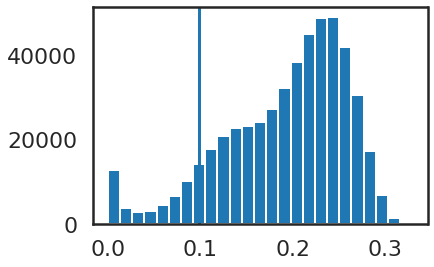

In [77]:
# Find the minima in curvature histrogram
q1 = np.quantile(curvatures,0.1)

#hist, bin_edges = np.histogram(curvatures,bins=25)
#maxima_idx = list(argrelmax(hist,mode='wrap')[0])
#minima_idx = [int(0.5*(maxima_idx[i]+maxima_idx[i+1])) for i in range(2)]
#minima = [0.5*(bin_edges[loc]+bin_edges[loc+1]) for loc in minima_idx]
#print(minima)
plt.hist(curvatures,bins=25)
plt.axvline(q1,0,7500)
plt.show()

In [86]:
fig = px.scatter_3d(df.sample(n=50000), x="x", y="y", z="z", color="curvature")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.update_layout(title='Curvature',
                            font=dict(
                            family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f"
                                )
                     )
fig.write_html('id13.curvature.3Dumap.html', auto_open=True)

df1 = df[df['curvature'] < q1] # define the low curvature sector

fig = px.scatter_3d(df1, x="x", y="y", z="z", color="curvature")
fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))
fig.update_layout(title='Curvature values in the first quartile',
                            font=dict(
                            family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f"
                                )
                     )
fig.write_html('id13.curvature_q1.3Dumap.html', auto_open=True)



Now we can try to cluster the points in the low curvature sector:

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/garner1/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



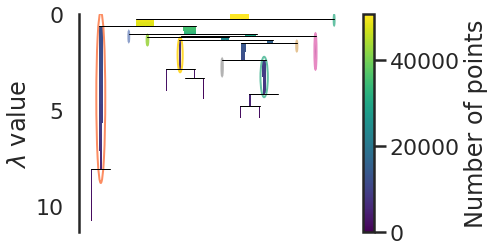

In [91]:
'''
UMAP representation of the morphology
'''
min_cluster_size = 1000 # parameter to be adjausted
min_samples = 100       # parameter to be adjausted
    
clusterer = hdbscan.HDBSCAN(min_samples=min_samples, 
                                min_cluster_size=min_cluster_size, 
                                gen_min_span_tree=True)
clusterer.fit(df1.loc[:,('x','y','z')]) 

clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    
df1['cluster'] = clusterer.labels_    # add cluster id to dataframe
df1['cluster'] = df1['cluster'].apply(str)   # make cluster id a string
df_filtered = df1[df1.cluster != str(-1)] # remove unassigned points
    
fig = px.scatter(df_filtered, x="cx", y="cy",color="cluster",
                     width=800, height=800,
                     color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=3,opacity=1))
fig.write_html('spatial_decoration.html', auto_open=True)
    
fig = px.scatter_3d(df_filtered, x="x", y="y", z="z", color="cluster", hover_name="cluster", 
                        color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=3,opacity=1.0),selector=dict(mode='markers'))
fig.write_html('low_curvature_clusters.html', auto_open=True)

Thinking of the pipeline as a tool we should aim at simplifying the visualization and adjusting the parameters in order for the user to tune the output to his need. 

In [113]:
# partition curvatures into quantiles
numb_quantiles =  10 # parameter to be adjausted
df['curvature_quantile'] = pd.qcut(curvatures,numb_quantiles, retbins=False, labels=False)
#df['curvature_quantile'] = df['curvature_quantile'].apply(str)   #make clustet id a string

# There is now direct correlation between curvature and morphological features, 
# but curvature can still be used to segment the manifold

#plt.scatter(df['area'], df['curvature'],s=1)
#plt.show()

min_cluster_size = 500 # parameter to be adjausted
min_samples = 50       # parameter to be adjausted
for q in range(numb_quantiles)[:]:
    df_quantile = df[df['curvature_quantile']==q]
    # Cluster the curvature's quantile of the point cloud

    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, 
                                min_cluster_size=min_cluster_size, 
                                gen_min_span_tree=True)
    clusterer.fit(df_quantile.loc[:,('x','y','z')]) 

#    clusterer.condensed_tree_.plot(select_clusters=True,selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    
    df_quantile['cluster'] = clusterer.labels_    # add cluster id to dataframe
    df_quantile['cluster'] = df_quantile['cluster'].apply(str)   # make cluster id a string
    df_filtered = df_quantile[df_quantile.cluster != str(-1)] # remove unassigned points

    
    fig = px.scatter(df_filtered, x="cx", y="cy",color="cluster",width=800, height=800)
    fig.update_traces(marker=dict(size=5,opacity=1),selector=dict(mode='markers'))
    
#    fig = px.scatter_3d(df_filtered, x="x", y="y", z="z", color="cluster", hover_name="cluster", 
#                        color_discrete_sequence=px.colors.qualitative.Set2)
#    fig.update_traces(marker=dict(size=1,opacity=0.75),selector=dict(mode='markers'))

    fig.write_html('test.html', auto_open=True)

In [33]:
'''
UMAP representation of the morphology
'''
df_embedding['curvature'] = pd.qcut(curvatures,10, retbins=False, labels=False)

fig = px.scatter_3d(df_embedding[df_embedding['curvature']==9], 
                    x="x", y="y", z="z", 
                    color="curvature", 
                    hover_name="curvature", 
                    color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=1,opacity=0.5),selector=dict(mode='markers'))

fig.write_html('test.html', auto_open=True)

In [225]:
if len(minima) == 2:
    df1 = df[df['curvature'] < minima[0]]
    df2 = df[(minima[0] <= df['curvature']) & (df['curvature'] < minima[1])]
    df3 = df[minima[1] <= df['curvature']]
if len(minima) == 1:
    df1 = df[df['curvature'] < minima[0]]
    df2 = df[minima[0] <= df['curvature']]